In [51]:
import gpflow
import numpy as np
import matplotlib
from gpflow.utilities import print_summary
from tensorflow_probability import bijectors as tfb
import tensorflow as tf



# The lines below are specific to the notebook format
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8, 5)
plt = matplotlib.pyplot

def bounded_parameter(low, high, param):
    """Make parameter tfp Parameter with optimization bounds."""

    sigmoid = tfb.Sigmoid(low=tf.cast(low, tf.float64), 
                          high=tf.cast(high, tf.float64),
                         name='sigmoid')
    parameter = gpflow.Parameter(param, transform=sigmoid, dtype=tf.float64)
    return parameter

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.lengthscale,Parameter,Sigmoid,,True,(),float64,0.6
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1


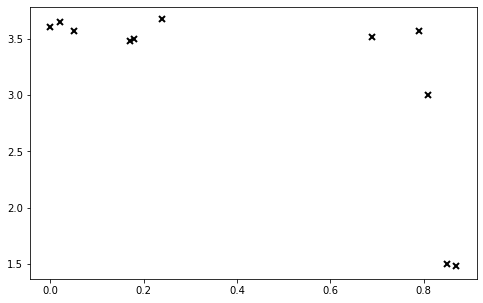

In [60]:
X = np.array([0, 0.02, 0.05, 0.17, 0.18, 0.24, 0.69, 0.79, 0.81, 0.85, 0.87]).reshape(-1,1)
Y = np.array([3.6, 3.65, 3.57, 3.48, 3.5, 3.67, 3.51, 3.57, 3.0, 1.5, 1.48]).reshape(-1,1)
plt.plot(X, Y, 'kx', mew=2);


k = gpflow.kernels.Matern52()
k.lengthscale = bounded_parameter(0.2, 1, 0.6)

m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)
m.likelihood.variance.assign(1)
# m.kernel.lengthscale.assign(0.3)
print_summary(m, fmt='notebook')

In [61]:
opt = gpflow.optimizers.Scipy()
def objective_closure():
    return - m.log_marginal_likelihood()

opt_logs = opt.minimize(objective_closure,
                        m.trainable_variables,
                        options=dict(maxiter=100))
print_summary(m, fmt='notebook')

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,7.66393
GPR.kernel.lengthscale,Parameter,Sigmoid,,True,(),float64,0.209426
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0361041


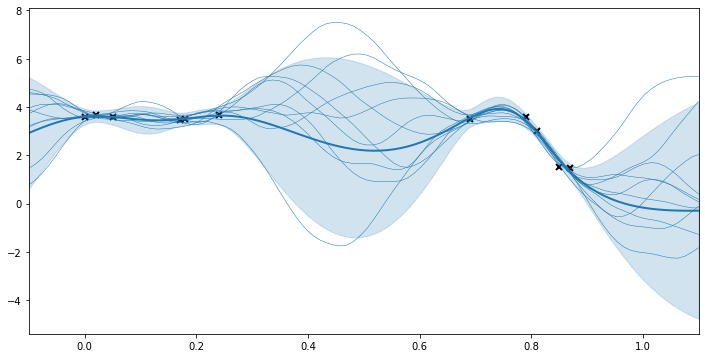

In [62]:
## generate test points for prediction
xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)  # test points must be of shape (N, D)

## predict mean and variance of latent GP at test points
mean, var = m.predict_f(xx)

## generate 10 samples from posterior
samples = m.predict_f_samples(xx, 10)  # shape (10, 100, 1)

## plot
plt.figure(figsize=(12, 6))
plt.plot(X, Y, 'kx', mew=2)
plt.plot(xx, mean, 'C0', lw=2)
plt.fill_between(xx[:,0],
                 mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                 mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                 color='C0', alpha=0.2)

plt.plot(xx, samples[:, :, 0].numpy().T, 'C0', linewidth=.5)
plt.xlim(-0.1, 1.1);
